# 2nd Level Model Structure: Reactive Stage

In [1]:
import sys
import os
import pickle
sys.path.append(os.path.abspath('..'))
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from pyomo import environ as pe
from global_sets.component import m
from utility.display_utility import trans_product_mole, trans_product_mass
from utility.model_utility import add_dual, update_dual, check_DOF

# stage construction rules
from physics.kinetics_bounded import kinetic_block_rule
from physics.energy_bounded import energy_block_rule
from physics.VLE_bounded import VLE_block_rule
from physics.MPCC_beta import beta_NCP_block_rule, beta_Reg_block_rule, beta_pf_block_rule

model = pe.ConcreteModel()

# Global Sets (Inlet / Outlet)

In [3]:
model.inlet = pe.Set(initialize=['in'])
model.outlet = pe.Set(initialize=['out','P'])
model.stream = model.inlet | model.outlet

# Global Variables

In [4]:
# Tray Inlet/Outlet Variable
model.x_ = pe.Var(model.inlet,m.COMP_TOTAL,within=pe.NonNegativeReals)
model.y_ = pe.Var(model.inlet,m.COMP_TOTAL,within=pe.NonNegativeReals)
model.x = pe.Var(m.COMP_TOTAL,within=pe.NonNegativeReals)
model.y = pe.Var(m.COMP_TOTAL,within=pe.NonNegativeReals)
model.z = pe.Var(m.COMP_FEED,within=pe.NonNegativeReals)

model.L = pe.Var(model.stream,within=pe.NonNegativeReals)
model.V = pe.Var(model.stream,within=pe.NonNegativeReals)
model.F = pe.Var(within=pe.NonNegativeReals)

model.H_L_ = pe.Var(model.inlet,within=pe.Reals)
model.H_V_ = pe.Var(model.inlet,within=pe.Reals)
model.H_L = pe.Var(within=pe.Reals)
model.H_V = pe.Var(within=pe.Reals)
model.H_F = pe.Var(within=pe.Reals)

# State Variable
model.T = pe.Var(within=pe.NonNegativeReals,bounds=(200+273.15,300+273.15)) # K
model.T_F = pe.Var(within=pe.NonNegativeReals) # K
model.P = pe.Var(within=pe.NonNegativeReals,bounds=(10,30)) # Bar

model.f_V = pe.Var(m.COMP_TOTAL,within=pe.NonNegativeReals,initialize=1e-20)
model.f_L = pe.Var(m.COMP_TOTAL,within=pe.NonNegativeReals,initialize=1e-20)

model.cat = pe.Var(within=pe.NonNegativeReals,initialize=3000) # kg
model.Q_main = pe.Var(within=pe.Reals) # MW
model.r_total_comp = pe.Var(m.COMP_TOTAL,within=pe.Reals) # kmol/s

# Construct Individual Blocks

In [5]:
model.kinetics_block = pe.Block(rule=kinetic_block_rule)

> Importing Kinetics Blocks......
> Adding the following local variable:
--------------------------------------------------
| kinetics_block.k_FT
| kinetics_block.r_FT_total
| kinetics_block.g0_FT
| kinetics_block.alpha
| kinetics_block.r_FT_cnum
| kinetics_block.r_FT_comp
| kinetics_block.k_WGS
| kinetics_block.Ke_WGS
| kinetics_block.r_WGS
| kinetics_block.r_WGS_comp
--------------------------------------------------



In [6]:
model.energy_block = pe.Block(rule=energy_block_rule)

> Importing Energy Blocks......
> Adding the following local variable:
--------------------------------------------------
| energy_block.dH_F
| energy_block.dH_V
| energy_block.dH_L
| energy_block.dH_vap
--------------------------------------------------



In [7]:
model.VLE_block = pe.Block(rule=VLE_block_rule)

> Importing VLE Blocks......
> Adding the following local variable:
--------------------------------------------------
| VLE_block.n_ave
| VLE_block.n_ave_cal
| VLE_block.Hen
| VLE_block.Hen0
| VLE_block.gamma
| VLE_block.P_sat
| VLE_block.P_sat_Y
| VLE_block.P_sat_dY_inf
| VLE_block.P_sat_dY0
| VLE_block.Hen_ref
| VLE_block.Hen0_ref
| VLE_block.gamma_ref
| VLE_block.V_L
| VLE_block.V_L_dY_inf
| VLE_block.V_L_dY0
| VLE_block.poynting
--------------------------------------------------



# Standard MESH Equations

## Mass Balance

\begin{equation}
Fz_{i}+\sum_{s\in{inlet}}L_{s}x'_{i,s}+\sum_{s\in{inlet}}V_{s}y'_{i,s}-\sum_{s\in{outlet}}L_{s}x_{i,s}+\sum_{s\in{ouelet}}V_{s}y_{i,s}+R_{i} = 0 \\
i = 1,...NC
\end{equation}

In [8]:
def mass_balance_main_rule(model,i):
    if i in m.COMP_FEED:
        return model.F*model.z[i] + sum(model.L[s]*model.x_[s,i] + model.V[s]*model.y_[s,i] for s in model.inlet)\
        + model.r_total_comp[i] - sum(model.L[s]*model.x[i] + model.V[s]*model.y[i] for s in model.outlet) == 0
    else:
        return sum(model.L[s]*model.x_[s,i] + model.V[s]*model.y_[s,i] for s in model.inlet)\
        + model.r_total_comp[i] - sum(model.L[s]*model.x[i] + model.V[s]*model.y[i] for s in model.outlet) == 0
model.mass_balance_main_con = pe.Constraint(m.COMP_TOTAL,rule=mass_balance_main_rule)

## Equilibrium

\begin{align}
&f_{i,V} = f_{i,L} \\
&i = 1,...NC
\end{align}

In [9]:
def VL_equil_rule(model,i):
    return model.f_V[i] == model.f_L[i]
model.VL_equil_con = pe.Constraint(m.COMP_TOTAL,rule=VL_equil_rule)

In [10]:
model.VL_equil_con.pprint()

VL_equil_con : Size=79, Index=COMP_TOTAL, Active=True
    Key     : Lower : Body                        : Upper : Active
     C10H20 :   0.0 :   f_V[C10H20] - f_L[C10H20] :   0.0 :   True
     C10H22 :   0.0 :   f_V[C10H22] - f_L[C10H22] :   0.0 :   True
     C11H22 :   0.0 :   f_V[C11H22] - f_L[C11H22] :   0.0 :   True
     C11H24 :   0.0 :   f_V[C11H24] - f_L[C11H24] :   0.0 :   True
     C12H24 :   0.0 :   f_V[C12H24] - f_L[C12H24] :   0.0 :   True
     C12H26 :   0.0 :   f_V[C12H26] - f_L[C12H26] :   0.0 :   True
     C13H26 :   0.0 :   f_V[C13H26] - f_L[C13H26] :   0.0 :   True
     C13H28 :   0.0 :   f_V[C13H28] - f_L[C13H28] :   0.0 :   True
     C14H28 :   0.0 :   f_V[C14H28] - f_L[C14H28] :   0.0 :   True
     C14H30 :   0.0 :   f_V[C14H30] - f_L[C14H30] :   0.0 :   True
     C15H30 :   0.0 :   f_V[C15H30] - f_L[C15H30] :   0.0 :   True
     C15H32 :   0.0 :   f_V[C15H32] - f_L[C15H32] :   0.0 :   True
     C16H32 :   0.0 :   f_V[C16H32] - f_L[C16H32] :   0.0 :   True
     C16

## MPCC: Beta

In [11]:
model.MPCC = pe.Block(rule = beta_NCP_block_rule)

> Importing MPCC_beta_NCP Blocks......
> Adding the following local variable:
--------------------------------------------------
| MPCC.beta
| MPCC.s_L
| MPCC.s_V
| MPCC.epi
--------------------------------------------------
> Adjusting the f_V = f_L bounds to f_V = beta * f_L



## Summation

\begin{equation}
\sum_ix_{i} = \sum_iy_{i} \\
F + L_{in} + V_{in} + R = L_{out} + V_{out}
\end{equation}

In [12]:
def summation_x_y_rule(model):
    return sum(model.x[i] for i in m.COMP_TOTAL) == sum(model.y[i] for i in m.COMP_TOTAL)
model.summation_x_y_con = pe.Constraint(rule=summation_x_y_rule)

def summation_total_mass_rule(model):
    return model.F + sum(model.L[s] + model.V[s] for s in model.inlet) + sum(model.r_total_comp[i] for i in m.COMP_TOTAL)\
            - sum(model.L[s] + model.V[s] for s in model.outlet) == 0
model.summation_total_mass_con = pe.Constraint(rule=summation_total_mass_rule)

## Energy Balance

\begin{equation}
F H_f+\sum_{s\in{inlet}}L_{s}H_{l,s}+\sum_{s\in{inlet}}V_{s}H_{v,s}-\sum_{s\in{outlet}}L_{s}H_{l,s}-\sum_{s\in{outlet}}V_{s}H_{v,s}+Q = 0
\end{equation}

In [13]:
def heat_balance_main_rule(model):
    return model.F*model.H_F + sum(model.L[s]*model.H_L_[s] + model.V[s]*model.H_V_[s] for s in model.inlet) \
            + model.Q_main - sum(model.L[s]*model.H_L + model.V[s]*model.H_V for s in model.outlet) == 0
model.heat_balance_main_con = pe.Constraint(rule=heat_balance_main_rule)

# Testing

In [14]:
add_dual(pe,model)

Created the follow pyomo suffixes:
ipopt_zL_out, ipopt_zU_out, ipopt_zL_in, ipopt_zU_in, dual


## Fixing In/Product Redundent Flow

In [15]:
model.x_.fix(0)
model.y_.fix(0)
model.L['in'].fix(0)
model.L['P'].fix(0)
model.V['in'].fix(0)
model.V['P'].fix(0)
model.H_L_.fix(0)
model.H_V_.fix(0)

## Fixing Model Parameters

In [16]:
model.cat.fix(3000)
model.P.fix(20)
model.T_F.fix(200+273.15)
model.F.fix(1)
model.z['CO'].fix(1/(1+0.8)-0/2)
model.z['H2'].fix(0.8/(1+0.8)-0/2)
model.z['C30H62'].fix(0)
model.VLE_block.n_ave.fix(20)

In [17]:
check_DOF(pe,model)

Active Equality Constraints:	 1184
Active Inequality Constraints:	 0
Active Variables:		 1357
Fixed Variables:		 172
DOF:				 1


## Fix T or to fix Q? we have found that Maximize against an upper bound is most reliable

In [18]:
model.T.setub(300+273.15)

In [19]:
# model.obj = pe.Objective(expr = model.L['out'],sense=pe.maximize)
# model.obj = pe.Objective(expr = model.cat,sense=pe.minimize)
model.obj = pe.Objective(expr = model.T ,sense=pe.maximize)

In [35]:
opt = pe.SolverFactory('ipopt')

opt.options['print_user_options'] = 'yes'
opt.options['linear_solver'] = 'ma86'

opt.options['linear_scaling_on_demand '] = 'no'
opt.options['linear_system_scaling '] = 'mc19'

opt.options['max_iter'] = 7000
results = opt.solve(model,tee=True)
update_dual(pe,model)

Ipopt 3.12.8: print_user_options=yes
linear_solver=ma86
linear_scaling_on_demand =no
linear_system_scaling =mc19
max_iter=7000


List of user-set options:

                                    Name   Value                used
                linear_scaling_on_demand = no                    yes
                           linear_solver = ma86                  yes
                   linear_system_scaling = mc19                  yes
                                max_iter = 7000                  yes
                      print_user_options = yes                   yes

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.8, running with

  72 -5.7315000e+02 3.06e-01 2.42e+09  -5.7 8.43e+02    -  7.86e-01 1.93e-01f  1
  73 -5.7315000e+02 5.55e-08 2.27e+07  -5.7 3.05e-01    -  8.88e-01 1.00e+00h  1
  74 -5.7315000e+02 1.54e-10 3.16e+01  -5.7 7.11e-04    -  1.00e+00 1.00e+00h  1
  75 -5.7315000e+02 2.85e-10 9.27e-06  -5.7 6.86e-05    -  1.00e+00 1.00e+00h  1
  76 -5.7315001e+02 4.50e-11 1.99e+00  -8.6 3.80e-04    -  1.00e+00 1.00e+00h  1
  77 -5.7315001e+02 1.92e-10 5.68e-11  -8.6 5.21e-08    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 77

                                   (scaled)                 (unscaled)
Objective...............:  -5.7315000572899407e+02   -5.7315000572899407e+02
Dual infeasibility......:   5.6827820227312031e-11    5.6827820227312031e-11
Constraint violation....:   1.9189402150621149e-10    1.9189402150621149e-10
Complementarity.........:   2.5059035596897228e-09    2.5059035596897228e-09
Overall NLP error.......:   2.5059035596897228e-09    2.5059035596897228e-09


Number of objective funct

In [21]:
model.T.value

573.15

In [22]:
model.MPCC.beta.value

0.12015583264388327

In [23]:
model.MPCC.s_L.value

0.8798447134527502

In [24]:
model.L['out'].value

2.8414104920246856e-07

In [25]:
print('Component\t\tLiquid: {:.4f}\t\t\tVapor: {:.4f}'.format(model.L['out'].value,model.V['out'].value))
print('-'*108)
for i in model.x:
    print('{:10s}'.format(i),'\t\t{:8.4%}\t\t\t{:8.4%}'.format(model.x[i].value,model.y[i].value))

Component		Liquid: 0.0000			Vapor: 0.4578
------------------------------------------------------------------------------------------------------------
H2         		 0.1371%			 0.3424%
CO         		 0.1236%			 0.2654%
CO2        		46.5965%			56.2353%
H2O        		10.9282%			 8.6187%
C2H4       		 5.6470%			 5.5917%
C3H6       		 5.8141%			 3.2153%
C4H8       		 2.3491%			 1.4282%
C5H10      		 1.6894%			 0.5529%
C6H12      		 1.3174%			 0.2585%
C7H14      		 0.9597%			 0.1208%
C8H16      		 0.6670%			 0.0565%
C9H18      		 0.4480%			 0.0264%
C10H20     		 0.2932%			 0.0123%
C11H22     		 0.1198%			 0.0037%
C12H24     		 0.0756%			 0.0017%
C13H26     		 0.0470%			 0.0008%
C14H28     		 0.0289%			 0.0004%
C15H30     		 0.0176%			 0.0002%
C16H32     		 0.0107%			 0.0001%
C17H34     		 0.0064%			 0.0000%
C18H36     		 0.0038%			 0.0000%
C19H38     		 0.0023%			 0.0000%
C20H40     		 0.0013%			 0.0000%
C1H4       		13.3744%			18.3934%
C2H6       		 3.2294%			 3.0063%
C3H8       		 1.3664%			

# Iterative Solve for Data Analysis

In [26]:
results_anchor = results
update_dual(pe,model)
model.solutions.store_to(results_anchor)

In [27]:
opt.options['warm_start_init_point'] = 'yes'
opt.options['warm_start_bound_push'] = 1e-20
opt.options['warm_start_mult_bound_push'] = 1e-20
opt.options['mu_init'] = 1e-6

In [28]:
catrange = [3000,1000,500,300,100,50,25,10]
Trange = np.linspace(300+273.15,200+273.15,26)

In [29]:
rf_data_master = {}

for c in catrange:
    model.del_component(model.obj)
    model.obj = pe.Objective(expr = model.cat ,sense=pe.minimize)

    model.solutions.load_from(results_anchor)
    update_dual(pe,model) 
       
    model.T.fix(300+273.15)
    # model.cat.fixed = False
    model.cat.fix(c)
    
    results_anchor = opt.solve(model,tee=False)
    model.solutions.store_to(results_anchor)
    update_dual(pe,model)
    
    model.del_component(model.obj)
    model.obj = pe.Objective(expr = model.T ,sense=pe.maximize)
    model.T.fixed = False
    model.cat.fixed = True
    
    
    print('\nWorking on Cat = {} kg'.format(model.cat.value))
    print('-'*108)
    
    rf_data = {}
    rf_data['x'] = {};rf_data['y'] = {};
    rf_data['T'] = []; rf_data['Q'] = []; rf_data['V'] = []; rf_data['L'] = []; rf_data['beta'] = []; 
    rf_data['s_L'] = [];
    for i in m.COMP_TOTAL:
        rf_data['x'][i] = []
        rf_data['y'][i] = []       

    for t in Trange:
        model.T.setub(t)
        results = opt.solve(model,tee=False)
        update_dual(pe,model)
        model.T.setub(300+273.15)
        print('Solved\t|T = {:.2f} K\t|V = {:.4f} kmol/s\t|L = {:.4f} kmol/s\t|s_L = {:.4f}\t|beta = {:.4f}'.\
              format(model.T.value,model.V['out'].value,model.L['out'].value,model.MPCC.s_L.value,model.MPCC.beta.value))
    
        rf_data['T'].append(model.T.value)
        rf_data['Q'].append(model.Q_main.value)
        rf_data['V'].append(model.V['out'].value)
        rf_data['L'].append(model.L['out'].value)
        rf_data['beta'].append(model.MPCC.beta.value)
        rf_data['s_L'].append(model.MPCC.s_L.value)

        for i in m.COMP_TOTAL:
            rf_data['x'][i].append(model.x[i].value)
            rf_data['y'][i].append(model.y[i].value)
        
    rf_data_master[c] = rf_data


Working on Cat = 3000 kg
------------------------------------------------------------------------------------------------------------
Solved	|T = 573.15 K	|V = 0.4578 kmol/s	|L = 0.0000 kmol/s	|s_L = 0.8798	|beta = 0.1202
Solved	|T = 569.15 K	|V = 0.4550 kmol/s	|L = 0.0000 kmol/s	|s_L = 0.8758	|beta = 0.1242
Solved	|T = 565.15 K	|V = 0.4520 kmol/s	|L = 0.0000 kmol/s	|s_L = 0.8709	|beta = 0.1291
Solved	|T = 561.15 K	|V = 0.4488 kmol/s	|L = 0.0000 kmol/s	|s_L = 0.8649	|beta = 0.1351
Solved	|T = 557.15 K	|V = 0.4455 kmol/s	|L = 0.0000 kmol/s	|s_L = 0.8574	|beta = 0.1426
Solved	|T = 553.15 K	|V = 0.4420 kmol/s	|L = 0.0000 kmol/s	|s_L = 0.8477	|beta = 0.1523
Solved	|T = 549.15 K	|V = 0.4384 kmol/s	|L = 0.0000 kmol/s	|s_L = 0.8347	|beta = 0.1653
Solved	|T = 545.15 K	|V = 0.4347 kmol/s	|L = 0.0000 kmol/s	|s_L = 0.8167	|beta = 0.1833
Solved	|T = 541.15 K	|V = 0.4309 kmol/s	|L = 0.0000 kmol/s	|s_L = 0.7902	|beta = 0.2098
Solved	|T = 537.15 K	|V = 0.4271 kmol/s	|L = 0.0000 kmol/s	|s_L = 0.7486	

Solved	|T = 537.15 K	|V = 0.5620 kmol/s	|L = 0.0000 kmol/s	|s_L = 0.8379	|beta = 0.1621
Solved	|T = 533.15 K	|V = 0.5866 kmol/s	|L = 0.0000 kmol/s	|s_L = 0.8143	|beta = 0.1857
Solved	|T = 529.15 K	|V = 0.6148 kmol/s	|L = 0.0000 kmol/s	|s_L = 0.7700	|beta = 0.2300
Solved	|T = 525.15 K	|V = 0.6456 kmol/s	|L = 0.0000 kmol/s	|s_L = 0.6782	|beta = 0.3218
Solved	|T = 521.15 K	|V = 0.6778 kmol/s	|L = 0.0000 kmol/s	|s_L = 0.4759	|beta = 0.5241
Solved	|T = 517.15 K	|V = 0.7101 kmol/s	|L = 0.0000 kmol/s	|s_L = 0.1284	|beta = 0.8716
Solved	|T = 513.15 K	|V = 0.7415 kmol/s	|L = 0.0000 kmol/s	|s_L = 0.0130	|beta = 0.9870
Solved	|T = 509.15 K	|V = 0.7711 kmol/s	|L = 0.0001 kmol/s	|s_L = 0.0032	|beta = 0.9968
Solved	|T = 505.15 K	|V = 0.7987 kmol/s	|L = 0.0002 kmol/s	|s_L = 0.0014	|beta = 0.9986
Solved	|T = 501.15 K	|V = 0.8238 kmol/s	|L = 0.0003 kmol/s	|s_L = 0.0008	|beta = 0.9992
Solved	|T = 497.15 K	|V = 0.8466 kmol/s	|L = 0.0004 kmol/s	|s_L = 0.0006	|beta = 0.9994
Solved	|T = 493.15 K	|V = 0.8670

Solved	|T = 493.15 K	|V = 0.9886 kmol/s	|L = 0.0000 kmol/s	|s_L = 0.0253	|beta = 0.9747
Solved	|T = 489.15 K	|V = 0.9902 kmol/s	|L = 0.0000 kmol/s	|s_L = 0.0163	|beta = 0.9837
Solved	|T = 485.15 K	|V = 0.9916 kmol/s	|L = 0.0000 kmol/s	|s_L = 0.0123	|beta = 0.9877
Solved	|T = 481.15 K	|V = 0.9929 kmol/s	|L = 0.0000 kmol/s	|s_L = 0.0103	|beta = 0.9897
Solved	|T = 477.15 K	|V = 0.9939 kmol/s	|L = 0.0000 kmol/s	|s_L = 0.0094	|beta = 0.9906
Solved	|T = 473.15 K	|V = 0.9949 kmol/s	|L = 0.0000 kmol/s	|s_L = 0.0092	|beta = 0.9908

Working on Cat = 10 kg
------------------------------------------------------------------------------------------------------------
Solved	|T = 573.15 K	|V = 0.9363 kmol/s	|L = 0.0000 kmol/s	|s_L = 0.9438	|beta = 0.0562
Solved	|T = 569.15 K	|V = 0.9432 kmol/s	|L = 0.0000 kmol/s	|s_L = 0.9446	|beta = 0.0554
Solved	|T = 565.15 K	|V = 0.9494 kmol/s	|L = 0.0000 kmol/s	|s_L = 0.9453	|beta = 0.0547
Solved	|T = 561.15 K	|V = 0.9551 kmol/s	|L = 0.0000 kmol/s	|s_L = 0.9460	|b

# Optimization results across disappearing phases

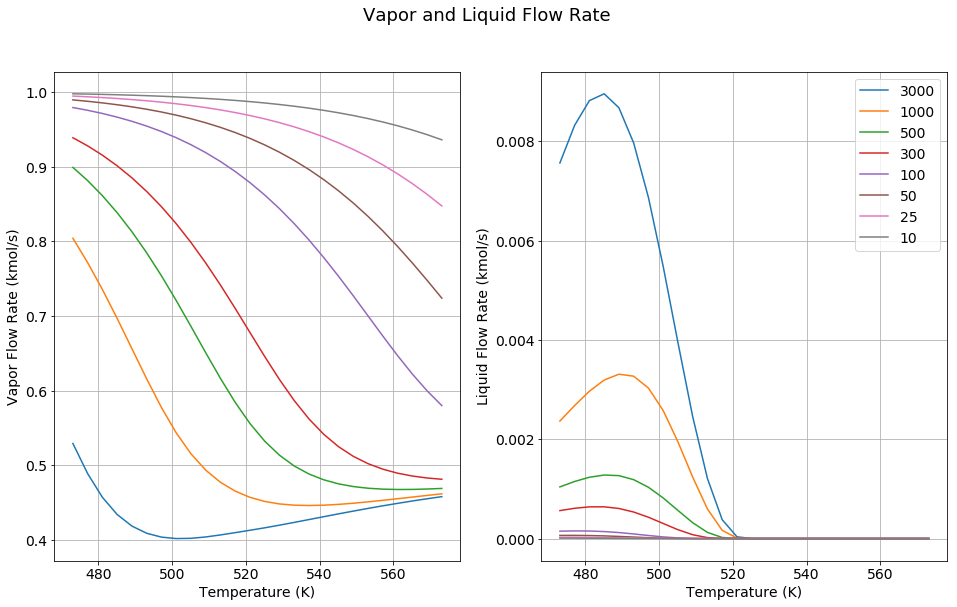

In [30]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,9))
for c in catrange:
    ax1.plot(Trange,rf_data_master[c]['V'])
ax1.set_ylabel('Vapor Flow Rate (kmol/s)',fontsize=14)
ax1.set_xlabel('Temperature (K)',fontsize=14)
ax1.tick_params(labelsize=14)
ax1.grid()

for c in catrange:
    ax2.plot(Trange,rf_data_master[c]['L'])
ax2.set_ylabel('Liquid Flow Rate (kmol/s)',fontsize=14)
ax2.set_xlabel('Temperature (K)',fontsize=14)
ax2.tick_params(labelsize=14)
ax2.grid()

ax2.legend(catrange,fontsize=14)
fig.suptitle('Vapor and Liquid Flow Rate',fontsize=18)

plt.show()

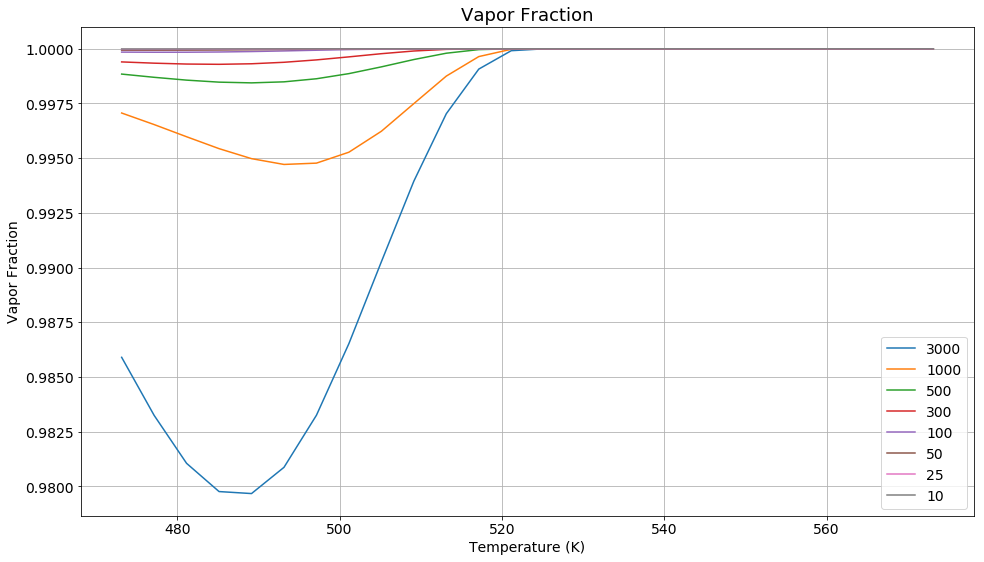

In [31]:
fig, ax1 = plt.subplots(figsize=(16,9))
for c in catrange:
    ax1.plot(Trange,np.divide(rf_data_master[c]['V'],np.add(rf_data_master[c]['V'],rf_data_master[c]['L'])))
ax1.set_ylabel('Vapor Fraction',fontsize=14)
ax1.set_xlabel('Temperature (K)',fontsize=14)
ax1.tick_params(labelsize=14)
ax1.legend(catrange,fontsize=14)
ax1.set_title('Vapor Fraction',fontsize=18)
ax1.grid()
plt.show()

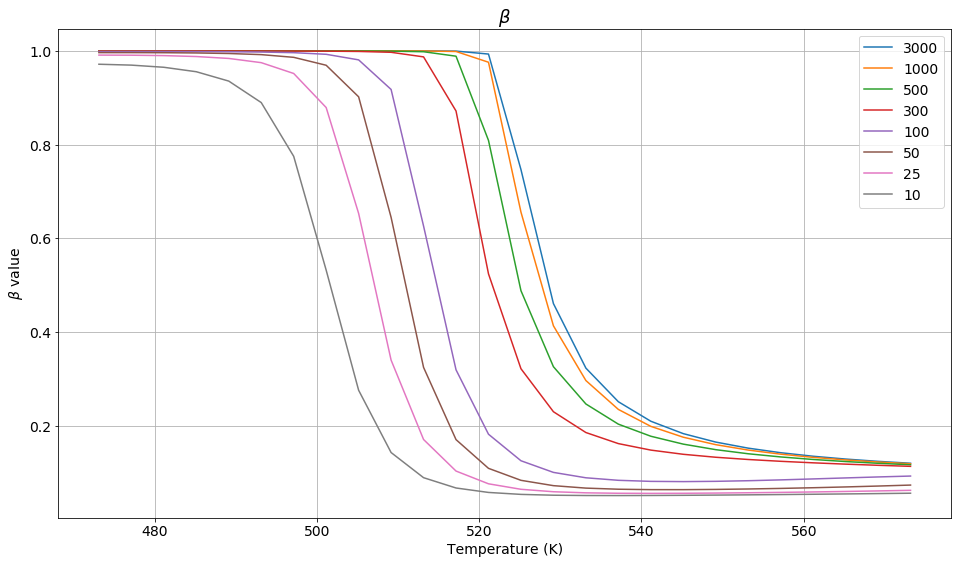

In [32]:
fig, ax1 = plt.subplots(figsize=(16,9))
for c in catrange:
    ax1.plot(Trange,rf_data_master[c]['beta'])
ax1.set_ylabel(r'$\beta$ value',fontsize=14)
ax1.set_xlabel('Temperature (K)',fontsize=14)
ax1.tick_params(labelsize=14)
ax1.legend(catrange,fontsize=14)
ax1.set_title(r'$\beta$',fontsize=18)
ax1.grid()
plt.show()

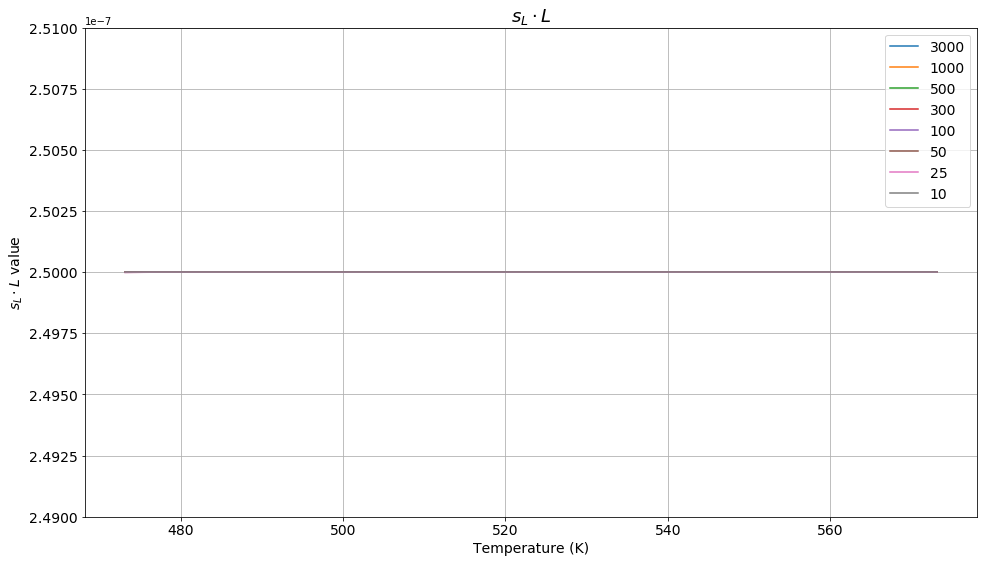

In [33]:
fig, ax1 = plt.subplots(figsize=(16,9))
for c in catrange:
    ax1.plot(Trange,np.multiply(rf_data_master[c]['s_L'],rf_data_master[c]['L']))
ax1.set_ylabel(r'$s_L \cdot L$ value',fontsize=14)
ax1.set_xlabel('Temperature (K)',fontsize=14)
ax1.tick_params(labelsize=14)
ax1.legend(catrange,fontsize=14)
ax1.set_ylim(2.49e-7,2.51e-7)
ax1.set_title(r'$s_L \cdot L$',fontsize=18)
ax1.grid()
plt.show()